## Transient Data Analysis

In [32]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import emcee 
import time
import corner
from scipy.stats import chi2 as CHI2

In [33]:
data = np.load(r"C:\Users\ricca\Documents\Unimib-Code\AstroStatistics\AML\Notebooks\AstroStatistics\Data\transient.npy")

In [34]:
Time = data.T[0]
vals = data.T[1]
errs = data.T[2]

In [35]:
# Define the likelihood function (PDF)
def pdf(x):
    """
    Probability density function for the transient data.
    
    Parameters
    ----------
    Time : array-like
        The time values.
    A : float
        The amplitude of the transient.
    b : float
        The constant offset of the transient.
    alpha : float
        The decay constant.
    x0 : float
        The time at which decay starts.
    
    Returns
    -------
    array-like
        The PDF evaluated at each time point.
    """
    if np.any(np.isinf(np.exp(-x[2] * (Time - x[3])))):
        return -np.inf
    output = np.where(Time > x[3], x[1] + x[0] * np.exp(-x[2] * (Time - x[3])), x[1])
    
    return output

def func(Time,A,b,alpha,t0):
    output = np.where(Time > t0, b + A * np.exp(-alpha * (Time -t0)),b)
    return output

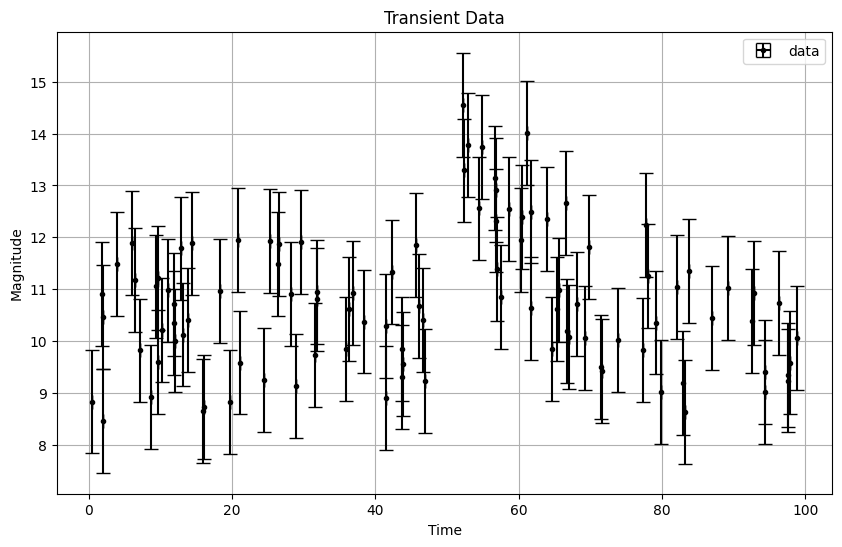

In [36]:
plt.figure(figsize=(10, 6))
plt.errorbar(Time, vals, xerr=0, yerr=errs,capsize=5, fmt=".", label="data", color='black')
plt.grid()
plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.title('Transient Data')
plt.legend()

Guess parameters estimates:
1. b = $ \frac{1}{30} \sum_{i=1}^{30} y_i$
2. A = $\max\{y\}$ - b
3. $\alpha = t$ | $ y(\alpha) = \frac{\max\{y\}}{e}$
4. $t_0 = t$ | $y(t) = \max\{y\} $ 

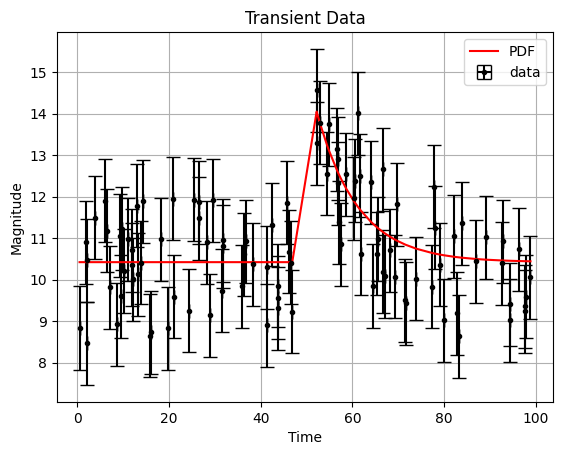

In [37]:
plt.errorbar(Time, vals, xerr=0, yerr=errs,capsize=5, fmt=".", label="data", color='black')
plt.plot(Time,func(Time,*np.array([max(vals)-vals[:20].mean(),vals[:20].mean(),1/9,np.argmax(vals)])), color='red', label="PDF")
plt.grid()
plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.title('Transient Data')
plt.legend()

In [38]:
from scipy import stats
import numpy as np

def prior(x):
    """
    Log prior for parameters [A, b, alpha, x0].
    Uniform priors:
    - A, b: between 0 and 50
    - alpha: between 0 and 100
    - x0: between exp(-5) and exp(5), uniform in log space
    """
    A, b, alpha, x0 = x

    if not (0 <= A <= 50 and 0 <= b <= 50 and 0 <= alpha <= 100 and np.exp(-5) <= x0 <= np.exp(5)):
        return -np.inf  # outside the prior bounds

    log_prior_A     = np.log(1.0 / 50)   # uniform(0, 50)
    log_prior_b     = np.log(1.0 / 50)
    log_prior_alpha = np.log(1.0 / 100)
    log_prior_x0    = np.log(1.0 / (np.exp(5) - np.exp(-5)))

    return log_prior_A + log_prior_b + log_prior_alpha + log_prior_x0

def log_likelihood(x):
    """
    Gaussian log-likelihood for the transient signal model. \
    If data follow the model +/- stocastic errors, the likelihood will follow the chi-squared distribution, with N-V degrees of freedom.
    Parameters
    ----------
    
    x : array-like
        The parameters [A, b, alpha, x0].
        
    Returns
    -------
    float
        The log-likelihood value.
    """
    y_model = pdf(x)  # or func(Time, *x)

    if np.any(np.isnan(y_model)) or np.any(~np.isfinite(y_model)):
        return -np.inf

    return -0.5 * np.sum(((vals - y_model) / errs)**2)


def posterior(x):
    """
    Log posterior function combining prior and likelihood.
    """
    
    log_prior_value = prior(x)
    if not np.isfinite(log_prior_value):
        return -np.inf

    log_like = log_likelihood(x)
    if not np.isfinite(log_like):
        return -np.inf

    return log_like + log_prior_value



In [39]:
ndim     = 4  # number of parameters in the model
nwalkers = 10  # number of MCMC walkers
nsteps   = int(1e5)  # number of MCMC steps to take **for each walker**

In [40]:
guess_parameters = np.array([max(vals)/2,vals[:20].mean(),0.2,50]) + np.random.randn(nwalkers, ndim) * 1e-6

In [41]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, posterior)
print("Starting MCMC...")
sampler.run_mcmc(guess_parameters, nsteps)

Starting MCMC...


State([[ 5.78392834 10.30621908  0.141076   48.87110292]
 [ 5.07474604 10.11401273  0.13556765 50.63743323]
 [ 4.77838467 10.34772933  0.11264739 49.31216412]
 [ 7.57910717 10.35651759  0.13280844 46.98156691]
 [ 5.27453993  9.99146967  0.13530592 50.23950012]
 [ 5.369763   10.39931741  0.11388619 48.36217355]
 [ 5.33042515 10.34243281  0.13105872 49.93698926]
 [ 4.12178749 10.02384957  0.13966717 51.73905703]
 [ 7.69566819 10.36916589  0.1723852  47.7784376 ]
 [ 6.26443692 10.31264758  0.11089453 47.15450766]], log_prob=[-67.00950635 -68.16438588 -66.49533322 -66.40669292 -71.32719253
 -66.78592054 -66.37315016 -71.36037281 -68.58849695 -66.31070875], blobs=None, random_state=('MT19937', array([4059773856,  306839621, 1961507246, 2068001669, 2176810509,
       3298341730,   83111642,  131299812,  794118246, 1717917152,
       1923983003, 2931347226,  971203017,   23126995, 1374979941,
       3870939709, 3499884526, 1293021626, 1774540332, 3080266679,
       1248444289, 3730710937, 113

In [42]:
tau = sampler.get_autocorr_time()

In [43]:
print(tau)

[94.03459707 70.07234025 75.48825578 89.95780399]


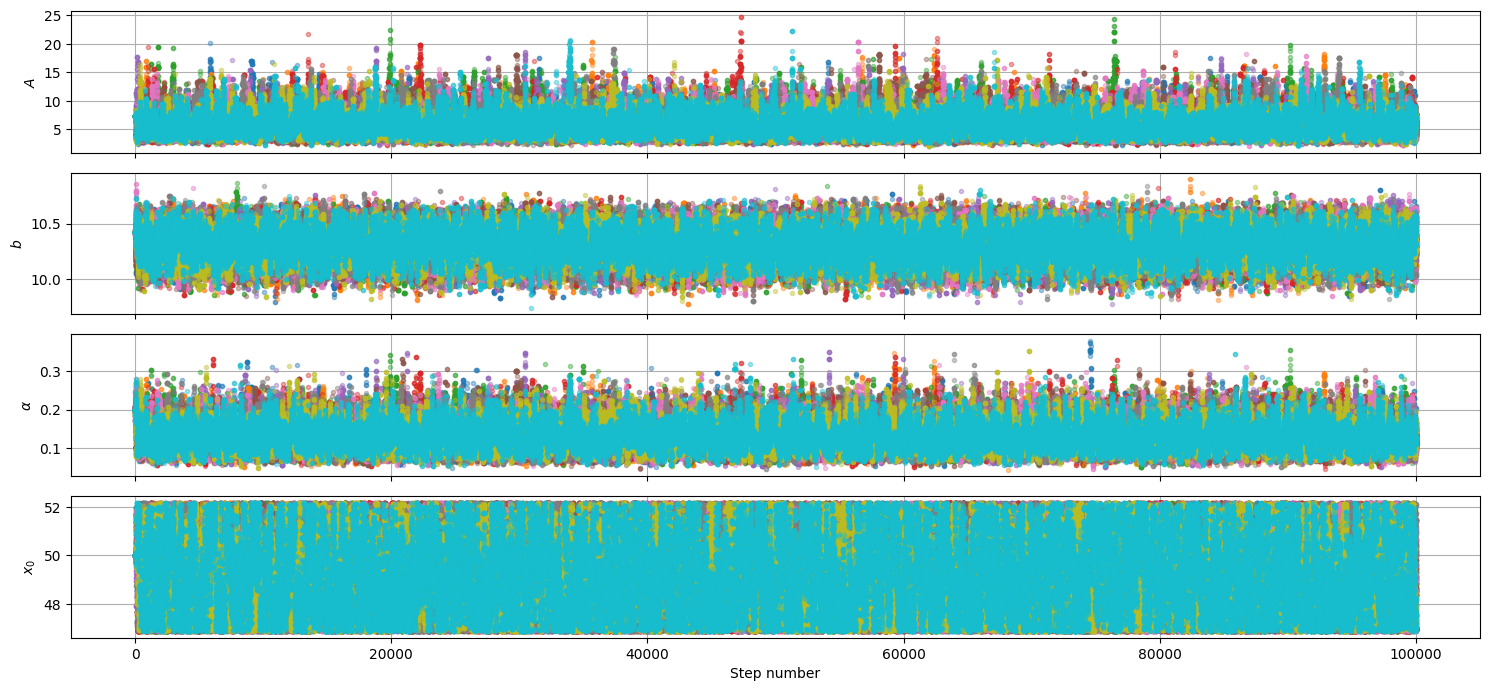

In [44]:
labels = [r"$A$", r"$b$", r"$\alpha$", r"$x_{0}$"]
fig, axes = plt.subplots(ndim, figsize=(15, 7), sharex=True)

for i in range(ndim):
    ax = axes[i]
    ax.plot(sampler.get_chain()[:,:,i], '.',alpha=0.4)
    ax.set_ylabel(labels[i])
    ax.grid(True)
axes[-1].set_xlabel("Step number")
plt.tight_layout()


In [45]:
burn_idx = 1000

Burn first burn_idx points

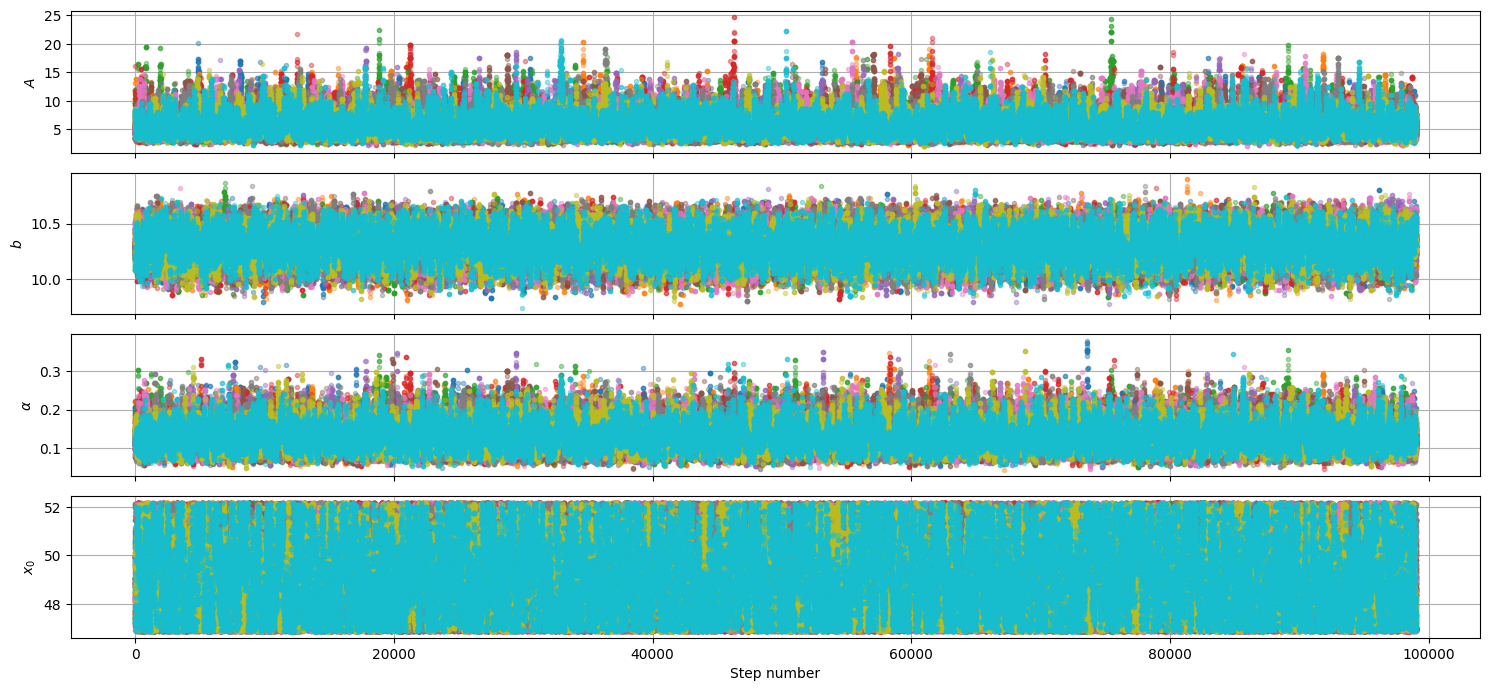

In [46]:
labels = [r"$A$", r"$b$", r"$\alpha$", r"$x_{0}$"]
fig, axes = plt.subplots(ndim, figsize=(15, 7), sharex=True)

for i in range(ndim):
    ax = axes[i]
    ax.plot(sampler.get_chain()[burn_idx:, :, i], '.',alpha=0.4)
    ax.set_ylabel(labels[i])
    ax.grid(True)
axes[-1].set_xlabel("Step number")
plt.tight_layout()


In [47]:
samples = sampler.get_chain(flat=False, discard=burn_idx, thin=int(max(tau)))
flat_samples = sampler.get_chain(flat=True, discard=burn_idx, thin=int(max(tau)))

In [48]:
quantiles = np.array([16, 50, 95])

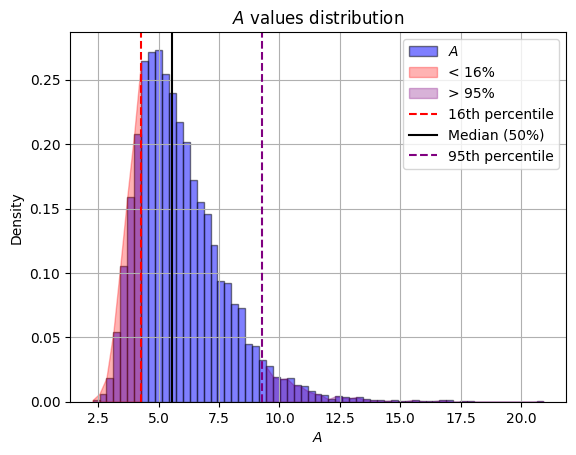

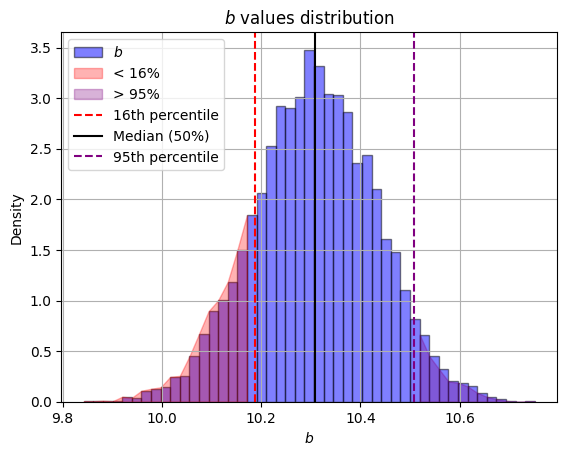

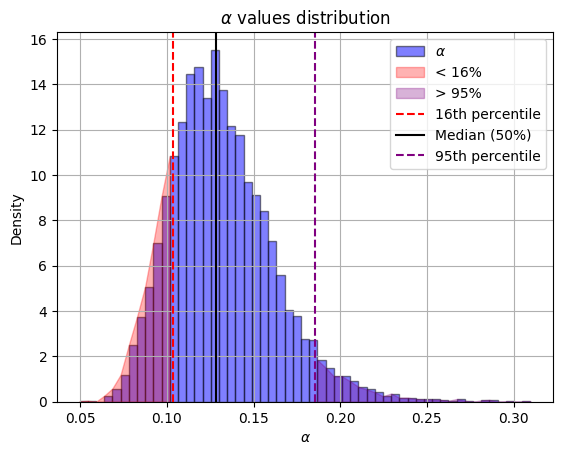

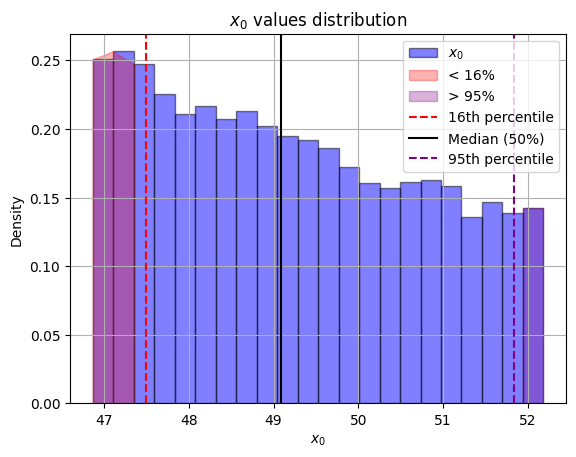

In [49]:
for i in range(4):
    q16, q50, q95 = np.percentile(flat_samples[:, i], quantiles)
    
    counts, bins, _ = plt.hist(flat_samples.T[i], bins='scott', density=True, histtype='barstacked', label=labels[i], alpha=0.5, color='blue', edgecolor='black')
    
    # Fill <16%
    mask_low = bins <= q16
    plt.fill_between(bins[mask_low], 0, np.interp(bins[mask_low], bins[:-1], counts), color='red', alpha=0.3, label='< 16%')

    # Fill >95%
    mask_high = bins >= q95
    plt.fill_between(bins[mask_high], 0, np.interp(bins[mask_high], bins[:-1], counts), color='purple', alpha=0.3, label='> 95%')

    # Vertical lines
    plt.axvline(q16, color='red', linestyle='--', label='16th percentile')
    plt.axvline(q50, color='black', linestyle='-', label='Median (50%)')
    plt.axvline(q95, color='purple', linestyle='--', label='95th percentile')
    
    
    plt.ylabel('Density')
    plt.xlabel(labels[i])
    plt.legend()
    plt.grid()
    plt.title(labels[i]+" values distribution")
    plt.show()

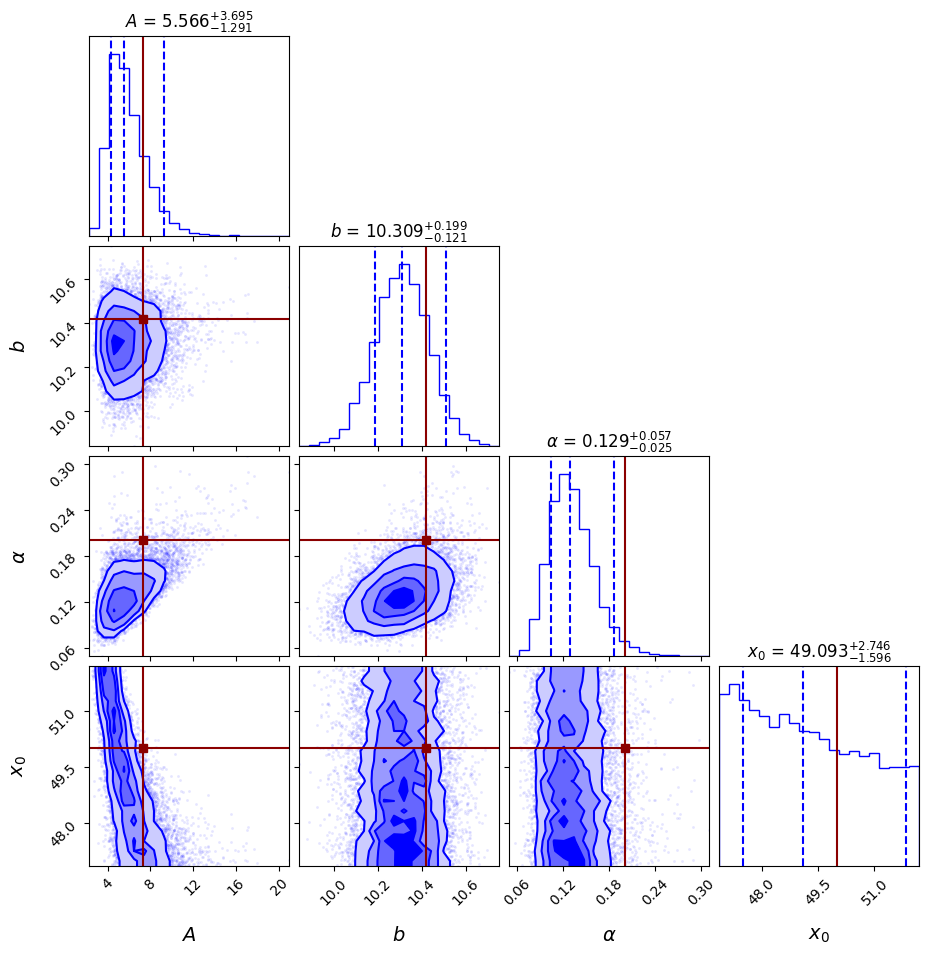

In [50]:
# Define true values (make sure vals is defined appropriately)
true_values = np.array([
    max(vals) / 2,
    np.mean(vals[:20]),
    0.2,
    50
])

# Generate corner plot
fig = corner.corner(
    flat_samples,
    labels=labels,  # customize these labels as needed
    truths=true_values,
    quantiles=quantiles*0.01,
    show_titles=True,
    title_fmt=".3f",              # Number format in titles
    title_kwargs={"fontsize": 12},
    label_kwargs={"fontsize": 14},
    truth_color="darkred",
    color="blue",
    fill_contours=True
)

In [51]:
mcmc_estimates = np.percentile(flat_samples, q=quantiles, axis=0)

for i, label in enumerate(labels):
    median = mcmc_estimates[1, i]
    minus = median - mcmc_estimates[0, i]
    plus = mcmc_estimates[2, i] - median

In [52]:
x_vals = np.random.uniform(0, samples.shape[0], 100).astype(int)
walker = np.random.randint(0, samples.shape[1], 1).astype(int)
p0 = samples[x_vals,walker,0]
p1 = samples[x_vals,walker,1]
p2 = samples[x_vals,walker,2]
p3 = samples[x_vals,walker,3]

Plotting + Null hypothesis test

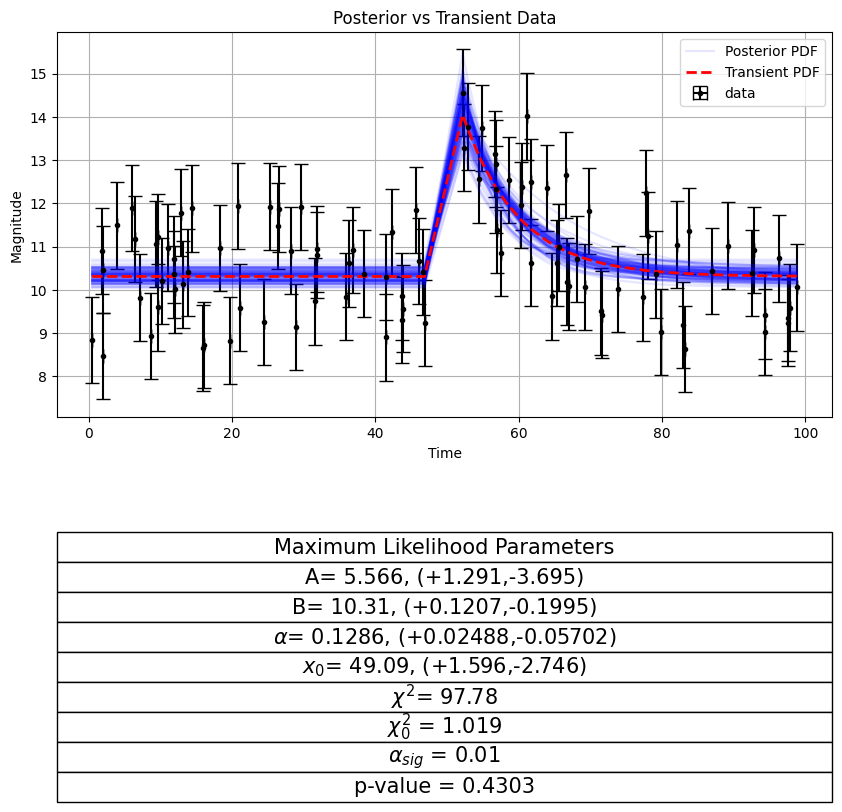

In [53]:
plt.figure(figsize=(10, 5))
plt.errorbar(Time, vals, xerr=0, yerr=errs,capsize=5, fmt=".", label="data", color='black')
for k in range(99):
    plt.plot(Time,func(Time,*np.array([p0[k],p1[k],p2[k],p3[k]])), color='blue', alpha=0.1)
plt.plot(Time,func(Time,*np.array([p0[99],p1[99],p2[99],p3[99]])), color='blue', alpha=0.1, label="Posterior PDF")
plt.plot(Time,func(Time,*np.array([mcmc_estimates[1, 0],mcmc_estimates[1, 1],mcmc_estimates[1, 2],mcmc_estimates[1, 3]])), linestyle="--",color='red', label="Transient PDF", linewidth=2)

plt.table(cellText=[[r"A"+f"= {mcmc_estimates[1, 0]:.4}, (+{mcmc_estimates[1,0] - mcmc_estimates[0,0]:.4},-{mcmc_estimates[2,0] - mcmc_estimates[1,0]:.4})"],
                    [r"B" +f"= {mcmc_estimates[1, 1]:.4}, (+{mcmc_estimates[1,1] - mcmc_estimates[0,1]:.4},-{mcmc_estimates[2,1] - mcmc_estimates[1,1]:.4})"],
                    [r"$\alpha$"+f"= {mcmc_estimates[1, 2]:.4}, (+{mcmc_estimates[1,2] - mcmc_estimates[0,2]:.4},-{mcmc_estimates[2,2] - mcmc_estimates[1,2]:.4})"],
                    [r"$x_0$"+f"= {mcmc_estimates[1, 3]:.4}, (+{mcmc_estimates[1,3] - mcmc_estimates[0,3]:.4},-{mcmc_estimates[2,3] - mcmc_estimates[1,3]:.4})"],
                    [r"$\chi^{2}$"+f"= {-2 * log_likelihood(mcmc_estimates[1]):.4}"],
                    [r"$\chi_0^{2}$"+f" = {-2 * log_likelihood(mcmc_estimates[1]) / (len(vals) - 4):.4}"],
                    [r"$\alpha_{sig}$ = 0.01"],
                    [f"p-value = {CHI2.sf(-2 * log_likelihood(mcmc_estimates[1]), len(vals) - 4):.4}"]],
         colLabels=["Maximum Likelihood Parameters"], loc='bottom', cellLoc='center', bbox=[0, -1, 1, 0.7], fontsize=15)


plt.grid()
plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.title('Posterior vs Transient Data')
plt.legend()

$p > \alpha_{sig} \to$ thus the empirical evidence is not strong enough to reject the null hypothesis. \
Data are compatible with the given model!

# Nested sampling

We have to define the prior transformations

In [54]:
from scipy.stats import loguniform
import matplotlib.pyplot as plt
import numpy as np
import dynesty

In [55]:
# Define the likelihood function (PDF)
def pdf2(x):
    """
    Probability density function for the transient data.
    
    Parameters
    ----------

    A : float
        The amplitude of the transient.
    b : float
        The constant offset of the transient.
    s : float
        Variance
    t0 : float
        The time at which decay starts.
    
    Returns
    -------
    array-like
        The PDF evaluated at each time point.
    """
    
    A, b, s, t0 = x
    
    output =  b + A * np.exp(-((Time - t0) ** 2) / (2 * s**2))
    
    return output

In [56]:
def prior(u):
    """
    Transform uniform samples to the parameter space.
    """
    # u is a uniform sample in [0, 1]
    
    x = np.array(u)

    x[0] = 50 * u[0] # A
    x[1] = 50 * u[1] # b
    x[2] = loguniform.ppf(u[2], np.exp(-5), np.exp(5)) # alpha
    x[3] = 100 * u[3] # t0
    
    return x

def prior2(u):
    """
    Transform uniform samples to the parameter space.
    """
    # u is a uniform sample in [0, 1]
    
    x = np.array(u)

    x[0] = (10 * u[0]) - 5 # A
    x[1] =  15 * u[1]      # b
    x[2] = 1/u[2] * 1/np.log(5/1) #loguniform distribution
    x[3] = (20*u[3] - 10) + 50 # t0
    
    return x

In [57]:
def log_likelihood(x):
    """
    Gaussian log-likelihood for the transient signal model.
    """    
    y_model = pdf(x)
    
    if np.any(np.isnan(y_model)) or np.any(~np.isfinite(y_model)):
        return -np.inf

        
    return  -0.5 * np.sum(((vals - y_model) / errs)**2) - 0.5*vals.shape[0]*np.sum(np.log(errs)) - vals.shape[0]*(np.log(2 * np.pi))

def log_likelihood2(x):
    """
    Gaussian log-likelihood for the transient signal model.
    """    
    y_model = pdf2(x)
    
    if np.any(np.isnan(y_model)) or np.any(~np.isfinite(y_model)):
        return -np.inf

        
    return  -0.5 * np.sum(((vals - y_model) / errs)**2) - 0.5*vals.shape[0]*np.sum(np.log(errs)) - vals.shape[0]*(np.log(2 * np.pi))

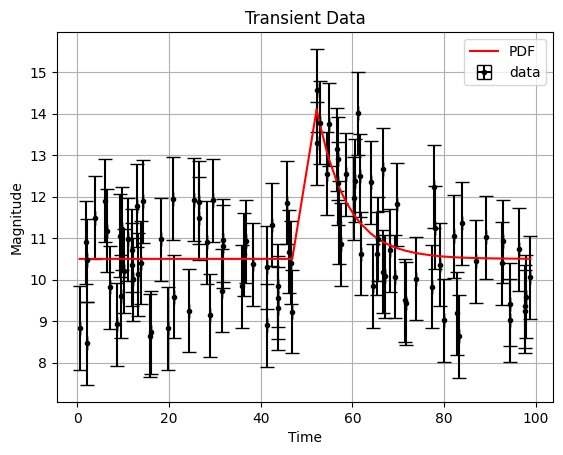

In [58]:
plt.errorbar(Time, vals, xerr=0, yerr=errs,capsize=5, fmt=".", label="data", color='black')
plt.plot(Time,pdf([5, 10.5, 0.15, 50]), color='red', label="PDF")
plt.grid()
plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.title('Transient Data')
plt.legend()

In [59]:
sampler = dynesty.DynamicNestedSampler(log_likelihood, prior, ndim=4, bound='multi', sample='auto')

In [60]:
sampler.run_nested(nlive_init=1000, nlive_batch=100, dlogz_init=100)

0it [00:00, ?it/s]C:\Users\ricca\AppData\Local\Temp\ipykernel_10244\3810404187.py:24: RuntimeWarning: overflow encountered in exp
  if np.any(np.isinf(np.exp(-x[2] * (Time - x[3])))):
C:\Users\ricca\AppData\Local\Temp\ipykernel_10244\3810404187.py:26: RuntimeWarning: overflow encountered in multiply
  output = np.where(Time > x[3], x[1] + x[0] * np.exp(-x[2] * (Time - x[3])), x[1])
3571it [00:15, 29.43it/s, batch: 0 | bound: 1 | nc: 7 | ncall: 34737 | eff(%):  9.992 | loglstar:   -inf < -443.108 <    inf | logz: -452.369 +/-    nan | dlogz: 211.906 > 100.000]     C:\Users\ricca\AppData\Local\Temp\ipykernel_10244\3810404187.py:24: RuntimeWarning: overflow encountered in exp
  if np.any(np.isinf(np.exp(-x[2] * (Time - x[3])))):
3684it [00:16, 127.34it/s, batch: 0 | bound: 1 | nc: 7 | ncall: 35616 | eff(%): 10.061 | loglstar:   -inf < -417.685 <    inf | logz: -426.458 +/-    nan | dlogz: 185.765 > 100.000] C:\Users\ricca\AppData\Local\Temp\ipykernel_10244\3810404187.py:26: RuntimeWarning

In [61]:
sresults = sampler.results

In [62]:
from dynesty import utils as dyfunc


# Extract sampling results.
samples = sresults.samples  # samples
weights = np.exp(sresults.logwt - sresults.logz[-1])  # normalized weights


evidence = sresults.logz[-1] #evidence
print("Bayesian evidence", np.exp(evidence))

# Compute 10%-90% quantiles.
quantiles = [dyfunc.quantile(samps, [0.16, 0.84], weights=weights)
             for samps in samples.T]
print('68% parameter credible regions are:\n ' + str(quantiles) + '\n')

# Compute weighted mean and covariance.
mean, cov = dyfunc.mean_and_cov(samples, weights)
labs = ['A', 'b', 'alpha', 't0']
print('Parameters:')
for m,c in zip(mean, np.sqrt(np.diag(cov))):
    print(f'{m:.3f} +/- {c:.3f}')

# Generate a new set of results with statistical+sampling uncertainties.
#results_sim = dyfunc.simulate_run(sresults)

Bayesian evidence 5.375976524084662e-108
68% parameter credible regions are:
 [[4.149744914315942, 7.192249992123717], [10.174583776984978, 10.419988203037024], [0.09903876410326125, 0.15165818462628783], [47.522767160029645, 51.05787604780189]]

Parameters:
5.682 +/- 1.625
10.297 +/- 0.122
0.125 +/- 0.028
49.235 +/- 1.515


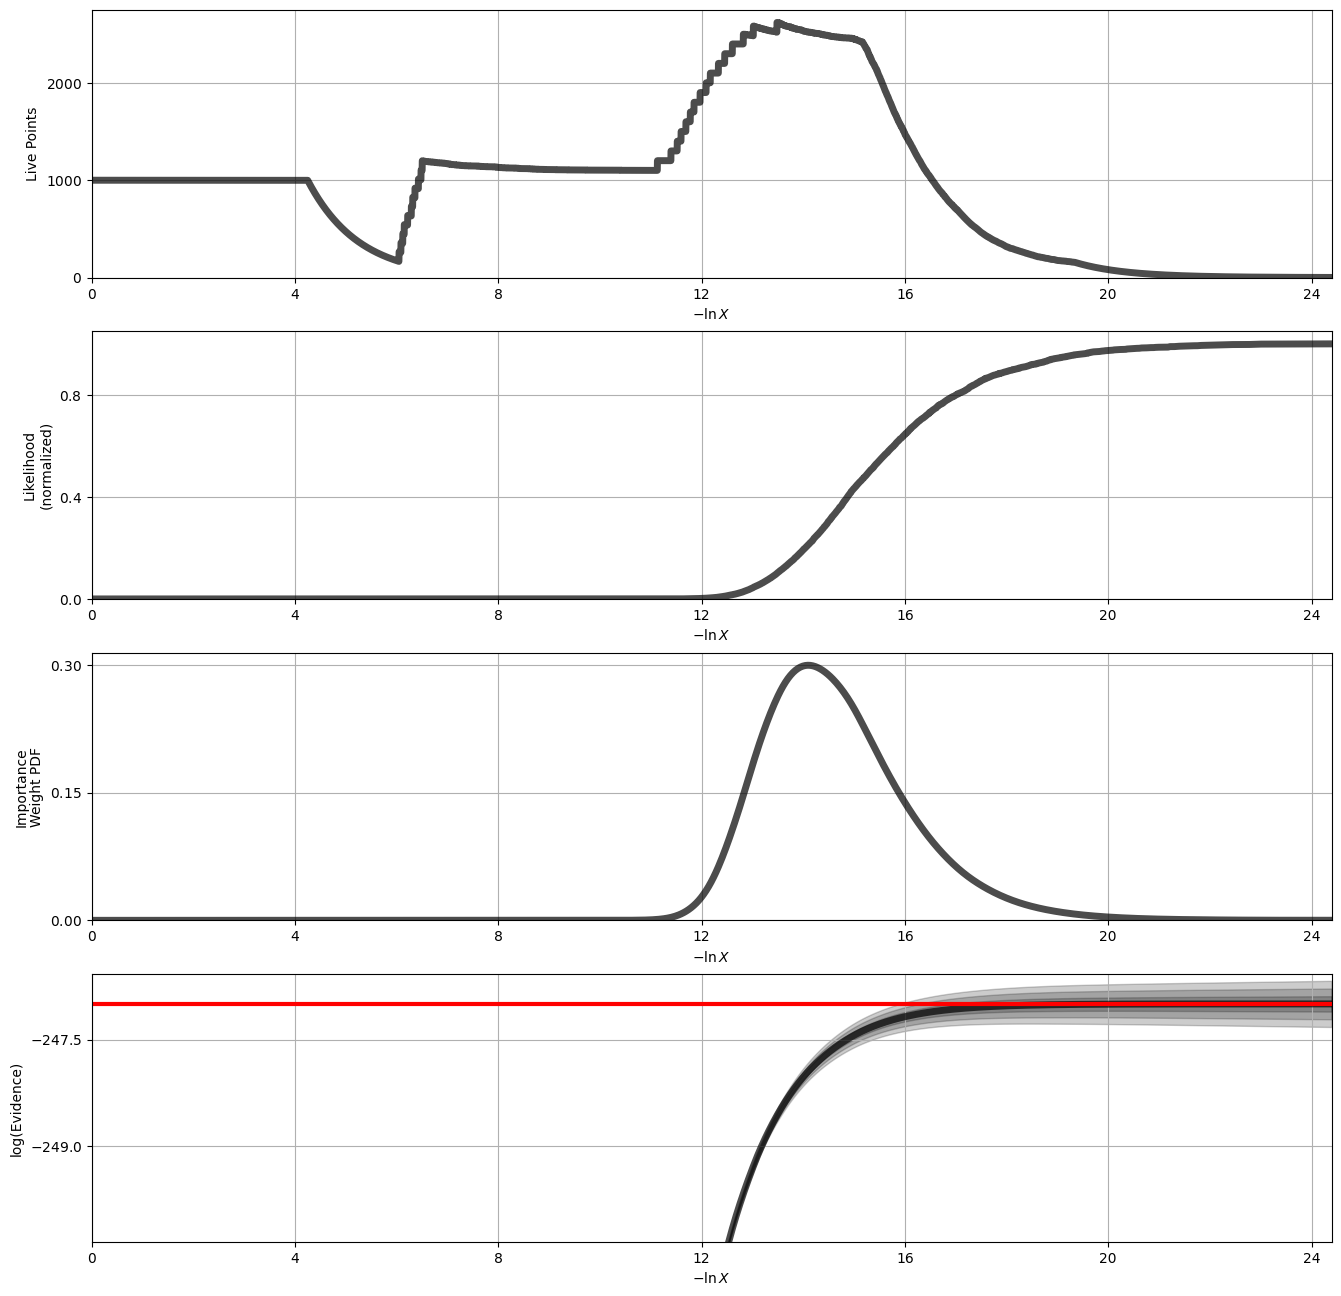

In [63]:
from dynesty import plotting as dyplot

# Plot a summary of the run.
rfig, raxes = dyplot.runplot(sresults, logplot=True, color='black', lnz_truth=evidence, truth_color='red', use_math_text=True)

raxes[0].grid()
raxes[1].grid()
raxes[2].grid()
raxes[3].grid()

plt.savefig(r'C:\Users\ricca\Documents\Unimib-Code\AstroStatistics\AML\Notebooks\AstroStatistics\ModelTest\live1.png')

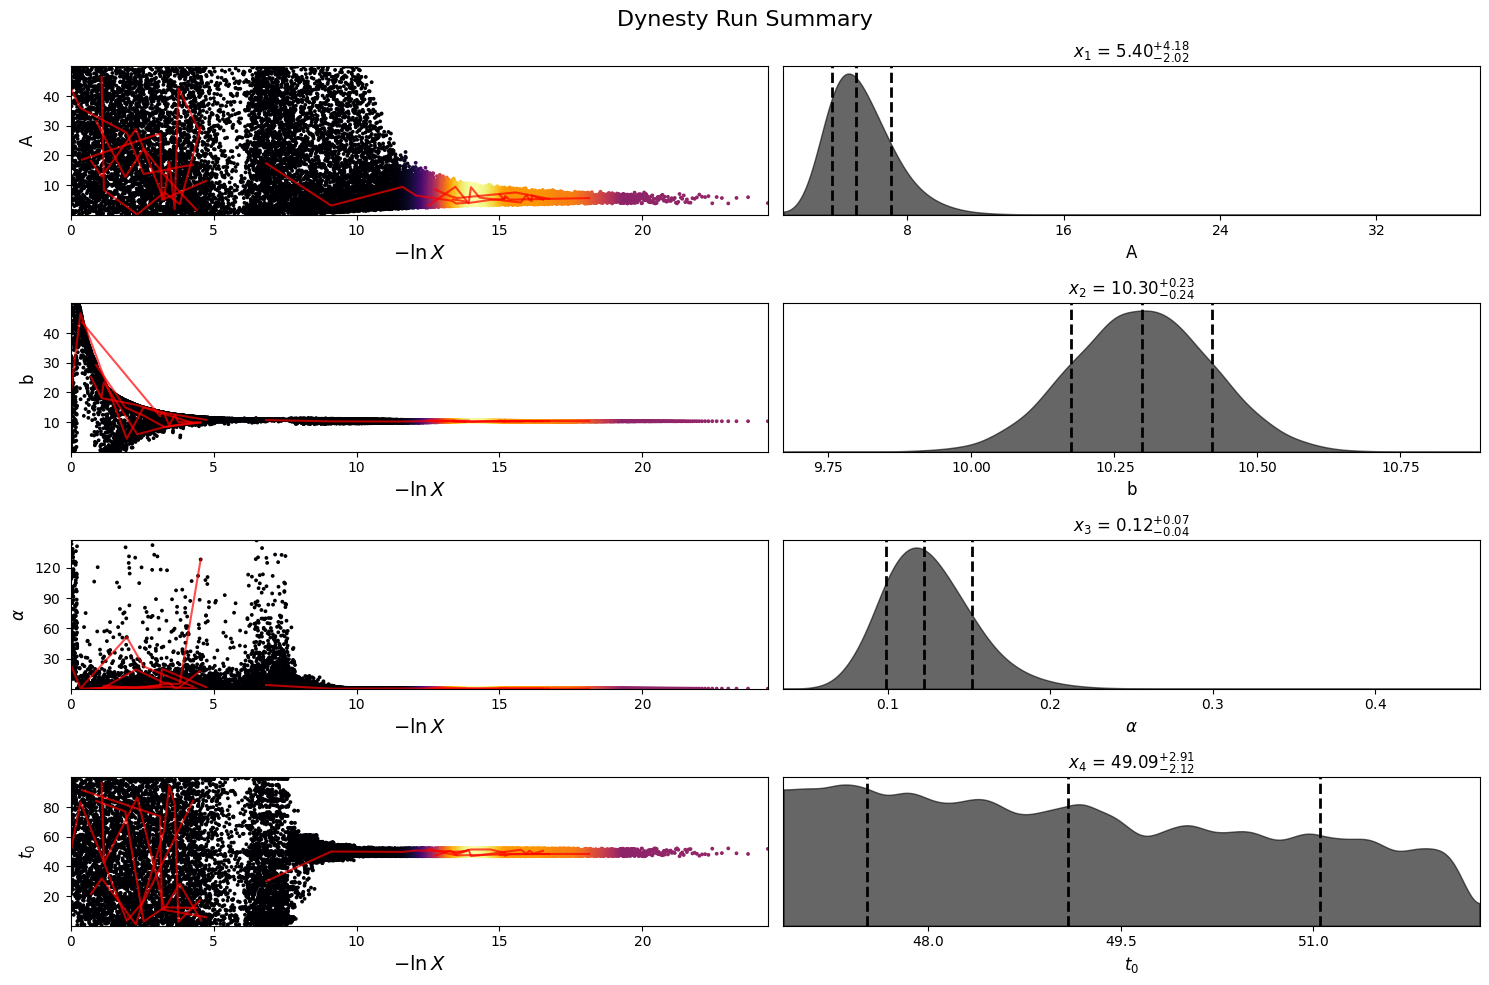

In [64]:
tfig, taxes = dyplot.traceplot(sresults, quantiles=[0.16, 0.5, 0.84], post_color='black', connect=True,  use_math_text=True, show_titles=True, title_kwargs={"fontsize": 12}, label_kwargs={"fontsize": 14}, truth_color='red', kde=False, trace_cmap='inferno')

tfig.suptitle("Dynesty Run Summary", fontsize=16)
taxes[0, 0].set_ylabel("A", fontsize=12)
taxes[1, 0].set_ylabel("b", fontsize=12)
taxes[2, 0].set_ylabel(r"$\alpha$", fontsize=12)
taxes[3, 0].set_ylabel(r"$t_0$", fontsize=12)
taxes[0, 1].set_xlabel("A", fontsize=12)
taxes[1, 1].set_xlabel("b", fontsize=12)
taxes[2, 1].set_xlabel(r"$\alpha$", fontsize=12)
taxes[3, 1].set_xlabel(r"$t_0$", fontsize=12)
tfig.set_size_inches(15, 10)
tfig.tight_layout()

plt.savefig(r'C:\Users\ricca\Documents\Unimib-Code\AstroStatistics\AML\Notebooks\AstroStatistics\ModelTest\traceplot1.png')


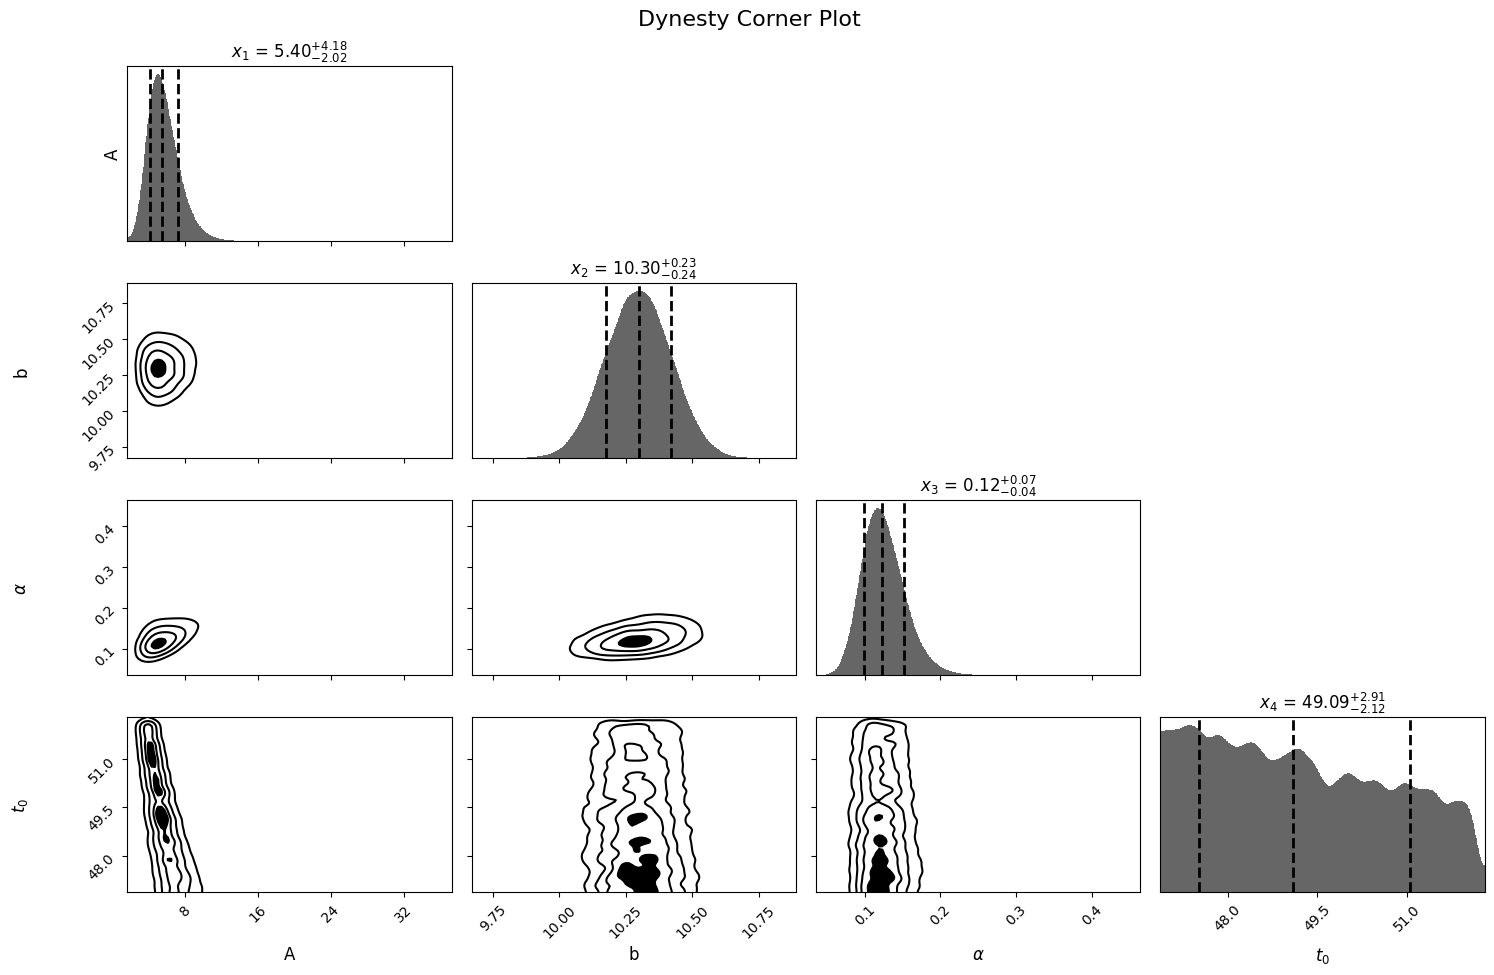

In [65]:
cfig, caxes = dyplot.cornerplot(sresults, color='black', quantiles=[0.16, 0.5, 0.84], show_titles=True)

caxes[0, 0].set_ylabel("A", fontsize=12)
caxes[1, 0].set_ylabel("b", fontsize=12)
caxes[2, 0].set_ylabel(r"$\alpha$", fontsize=12)
caxes[3, 0].set_ylabel(r"$t_0$", fontsize=12)

caxes[3, 0].set_xlabel("A", fontsize=12)
caxes[3, 1].set_xlabel("b", fontsize=12)
caxes[3, 2].set_xlabel(r"$\alpha$", fontsize=12)
caxes[3, 3].set_xlabel(r"$t_0$", fontsize=12)
cfig.suptitle("Dynesty Corner Plot", fontsize=16)
cfig.set_size_inches(15, 10)
cfig.tight_layout()

plt.savefig(r'C:\Users\ricca\Documents\Unimib-Code\AstroStatistics\AML\Notebooks\AstroStatistics\ModelTest\corner1.png')

In [66]:
sampler2 = dynesty.DynamicNestedSampler(log_likelihood2, prior2, ndim=4, bound='multi', sample='auto')

In [67]:
sampler2.run_nested(nlive_init=300, nlive_batch=100, dlogz_init=100)

869it [00:00, 1036.31it/s, batch: 1 | bound: 0 | nc: 93 | ncall: 2072 | eff(%): 41.940 | loglstar: -251.286 < -272.759 <    inf | logz: -252.744 +/-  2.376 | stop: 9750.048]         c:\Users\ricca\Documents\Unimib-Code\AstroStatistics\AML\Lib\site-packages\dynesty\bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
c:\Users\ricca\Documents\Unimib-Code\AstroStatistics\AML\Lib\site-packages\dynesty\bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a v

In [68]:
sresults2 = sampler2.results

In [69]:
# Extract sampling results.
samples = sresults2.samples  # samples
weights = np.exp(sresults2.logwt - sresults2.logz[-1])  # normalized weights


evidence2 = sresults2.logz[-1] #evidence
print("Bayesian evidence", np.exp(evidence2))

# Compute 10%-90% quantiles.
quantiles = [dyfunc.quantile(samps, [0.16, 0.84], weights=weights)
             for samps in samples.T]
print('68% parameter credible regions are:\n ' + str(quantiles) + '\n')

# Compute weighted mean and covariance.
mean, cov = dyfunc.mean_and_cov(samples, weights)
labs = ['A', 'b', 'alpha', 't0']
print('Parameters:')
for m,c in zip(mean, np.sqrt(np.diag(cov))):
    print(f'{m:.3f} +/- {c:.3f}')

# Generate a new set of results with statistical+sampling uncertainties.
#results_sim = dyfunc.simulate_run(sresults)

Bayesian evidence 2.653724487257715e-108
68% parameter credible regions are:
 [[2.3988394581837813, 3.1644001591483932], [10.202933905209944, 10.447436204191403], [4.296326345439369, 5.980253856932235], [54.34140660195809, 56.33454865270299]]

Parameters:
2.786 +/- 0.393
10.326 +/- 0.122
5.136 +/- 0.870
55.335 +/- 1.000


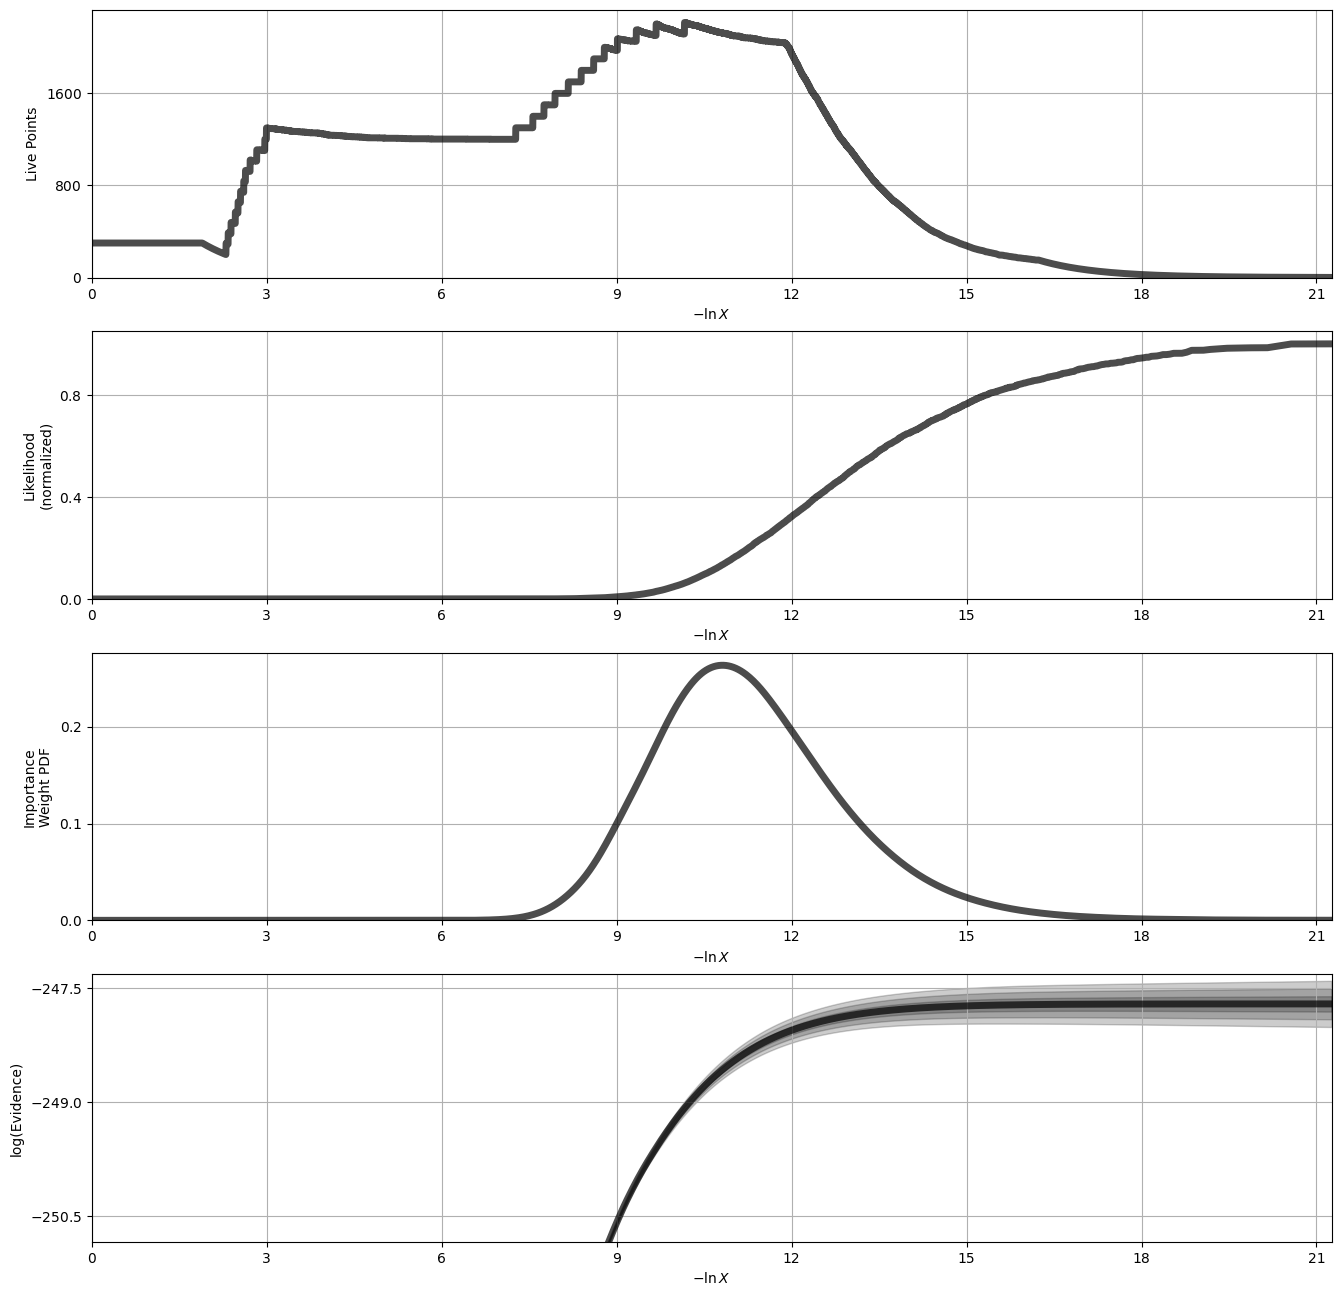

In [70]:
from dynesty import plotting as dyplot

# Plot a summary of the run.
rfig, raxes = dyplot.runplot(sresults2, logplot=True, color='black', lnz_truth=evidence, truth_color='red', use_math_text=True)

raxes[0].grid()
raxes[1].grid()
raxes[2].grid()
raxes[3].grid()

plt.savefig(r'C:\Users\ricca\Documents\Unimib-Code\AstroStatistics\AML\Notebooks\AstroStatistics\ModelTest\live2.png')

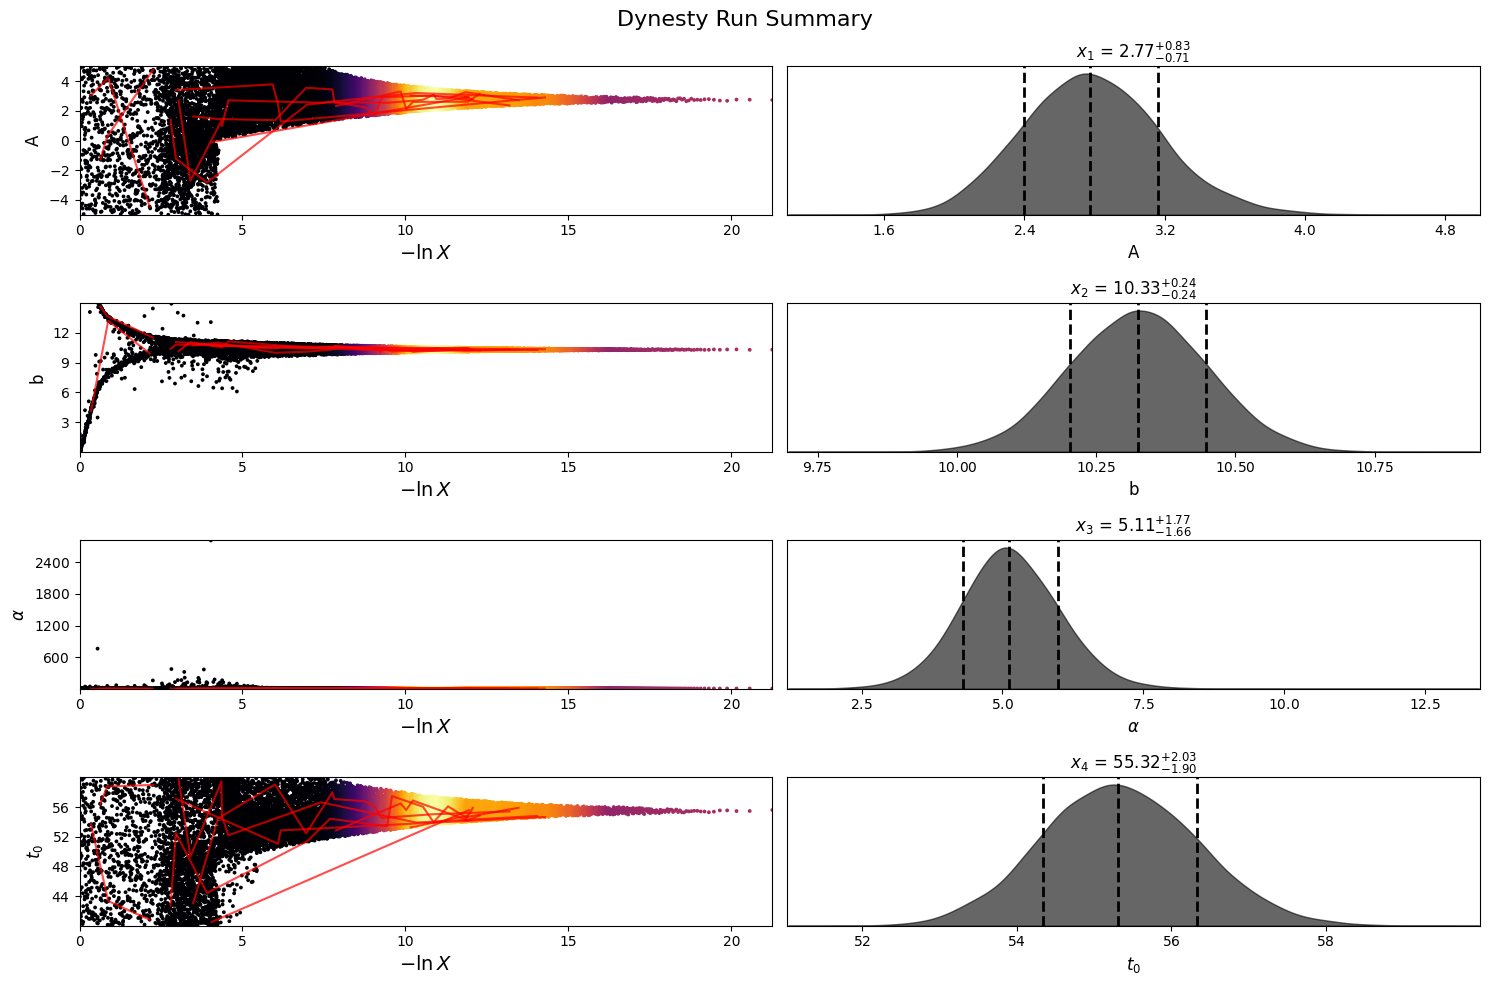

In [71]:
tfig, taxes = dyplot.traceplot(sresults2, quantiles=[0.16, 0.5, 0.84], post_color='black', connect=True,  use_math_text=True, show_titles=True, title_kwargs={"fontsize": 12}, label_kwargs={"fontsize": 14}, truth_color='red', kde=False, trace_cmap='inferno')

tfig.suptitle("Dynesty Run Summary", fontsize=16)
taxes[0, 0].set_ylabel("A", fontsize=12)
taxes[1, 0].set_ylabel("b", fontsize=12)
taxes[2, 0].set_ylabel(r"$\alpha$", fontsize=12)
taxes[3, 0].set_ylabel(r"$t_0$", fontsize=12)
taxes[0, 1].set_xlabel("A", fontsize=12)
taxes[1, 1].set_xlabel("b", fontsize=12)
taxes[2, 1].set_xlabel(r"$\alpha$", fontsize=12)
taxes[3, 1].set_xlabel(r"$t_0$", fontsize=12)
tfig.set_size_inches(15, 10)
tfig.tight_layout()

plt.savefig(r'C:\Users\ricca\Documents\Unimib-Code\AstroStatistics\AML\Notebooks\AstroStatistics\ModelTest\traceplot2.png')


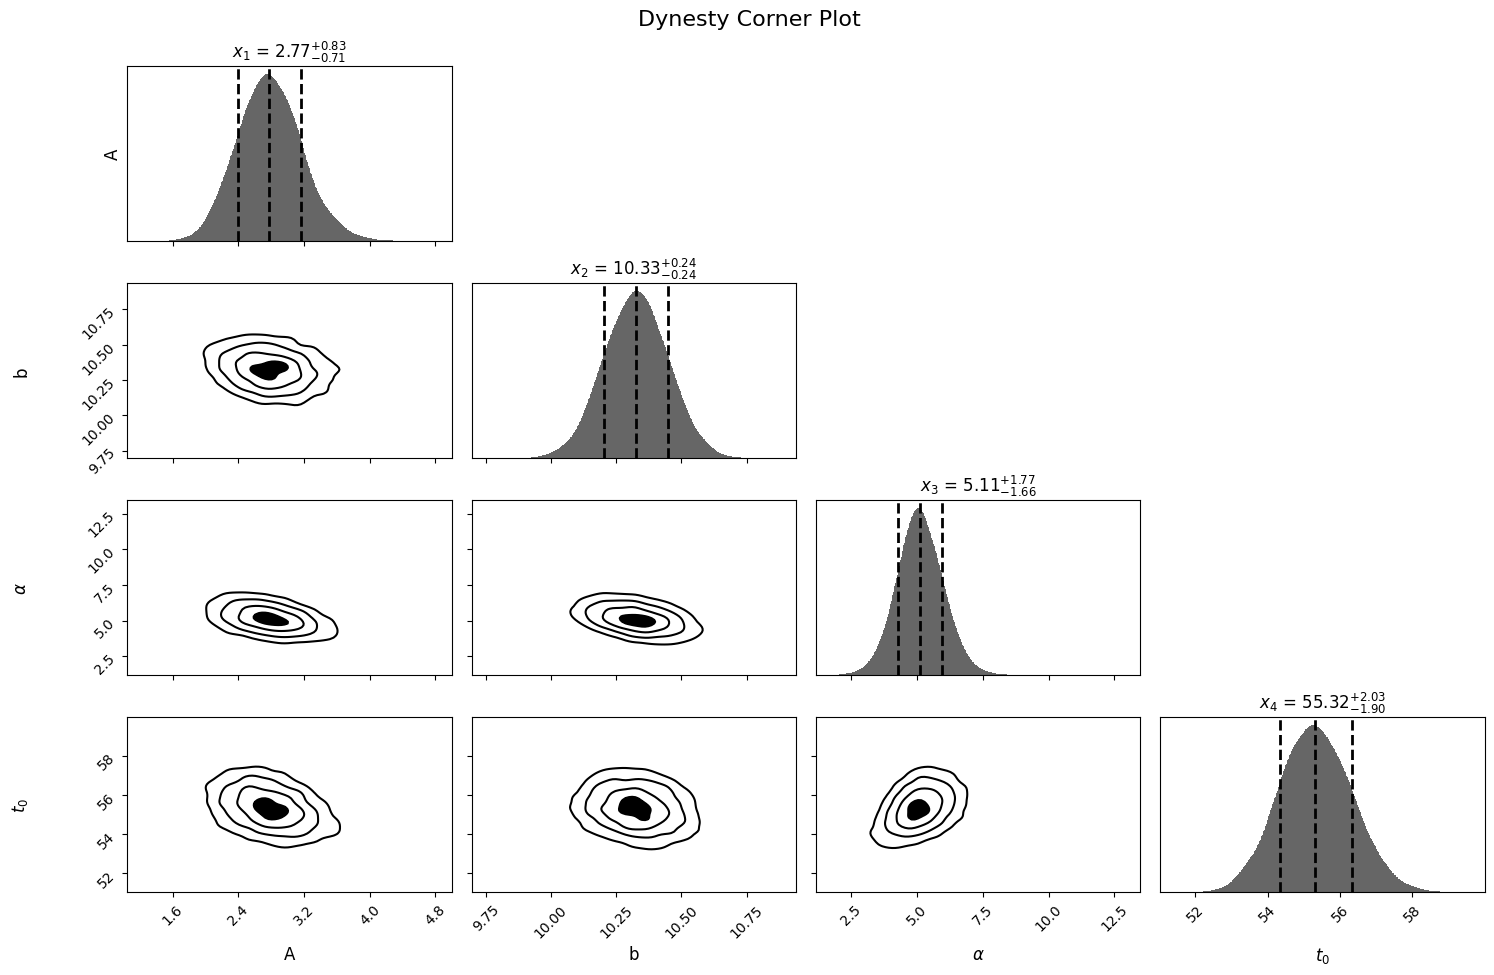

In [72]:
cfig, caxes = dyplot.cornerplot(sresults2, color='black', quantiles=[0.16, 0.5, 0.84], show_titles=True)

caxes[0, 0].set_ylabel("A", fontsize=12)
caxes[1, 0].set_ylabel("b", fontsize=12)
caxes[2, 0].set_ylabel(r"$\alpha$", fontsize=12)
caxes[3, 0].set_ylabel(r"$t_0$", fontsize=12)

caxes[3, 0].set_xlabel("A", fontsize=12)
caxes[3, 1].set_xlabel("b", fontsize=12)
caxes[3, 2].set_xlabel(r"$\alpha$", fontsize=12)
caxes[3, 3].set_xlabel(r"$t_0$", fontsize=12)
cfig.suptitle("Dynesty Corner Plot", fontsize=16)
cfig.set_size_inches(15, 10)
cfig.tight_layout()

plt.savefig(r'C:\Users\ricca\Documents\Unimib-Code\AstroStatistics\AML\Notebooks\AstroStatistics\ModelTest\corner2.png')

In [73]:
print(f"Bayes Factor : {evidence/evidence2}")

Bayes Factor : 0.9971499114973709
